# Regression:

This notebook contains an implementation with all necessary steps to perform dual annealing regression using the trained CVAE. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import torch
import pandas as pd
import nn_tools as nt
import os
import json
import glob
from scipy.interpolate import griddata
import random
import torch.nn as nn
from tqdm import tqdm
from copy import deepcopy
import optuna
from concurrent.futures import ThreadPoolExecutor

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print("Cuda found and in use")

elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    print('MPS Found and in use')
else:
    print("No GPU found; Performance will be poor")

MPS Found and in use


/opt/anaconda3/envs/msci_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calculate_histogram_area(df):
    """
    Calculate the area under a 4D histogram.

    Args:
        df (pd.DataFrame): DataFrame with 4 columns for bin centers and a 5th column for bin heights.

    Returns:
        float: Total area under the histogram.
    """
    # Min-Maxed Bin-Volumes to be Consistent with cos-squared signal measure
    x_unq = np.linspace(0.05, 0.95, 10)
    bin_width = x_unq[1] - x_unq[0]
    bin_volume = bin_width**4

    # Sum the bin heights and multiply by the bin volume
    total_area = df['bin_height'].sum() * bin_volume

    return total_area

def cos_squared_4d():
    """
    Generate a cos-squared signal using np.linspace spanning (0, 1) with 10 points for 4 dimensions.
    """
    # Generate linspace for each dimension
    x_unq = np.linspace(0.05, 0.95, 10)  # 10 points including 0 and 1

    # Create a meshgrid for 4D evaluation
    X, Y, Z, W = np.meshgrid(x_unq, x_unq, x_unq, x_unq, indexing='ij')

    # Compute the cos-squared signal for the 4D function
    cos_squared_signal = (
        np.cos(np.pi * X)**2 +
        np.cos(np.pi * Y)**2 +
        np.cos(np.pi * Z)**2 +
        np.cos(np.pi * W)**2
    )
    bin_width = x_unq[1] - x_unq[0]  # Uniform bin width
    bin_volume = bin_width**4        # 4D bin volume

    # Compute the total area under the signal
    total_area = np.sum(cos_squared_signal) * bin_volume

    # Normalise Signal Volume
    rescaled_bkg = cos_squared_signal / total_area

    return rescaled_bkg.ravel()

## Model Passthrough Functions

These are important to conduct the model passthrough for the trial evaluations run in the dual annealing algorithm on scipy. These are integrated into the objective function (to be minimised by the algo) seen later.

In [3]:
def model_outputs_linear(wilson, model_linear):
    input = torch.Tensor(np.array([wilson])).to(DEVICE)
    
    # =-=-= Linear Method of Reading Outputs =-=-=
    outputs = model_linear(input)
    outputs = outputs.to('cpu')
    
    return outputs.detach().numpy()

def model_outputs_CVAE(wilson, model_cvae, num_wc, bkg_signal):
    input = torch.Tensor(np.array([wilson[:num_wc]])).to(DEVICE)

    # =-=-= CVAE Method of Reading Outputs =-=-=
    outputs = model_cvae.generate_histogram(input)
    outputs = outputs.to('cpu')

    if num_wc != len(wilson):
        beta = wilson[num_wc]

        outputs = outputs + beta * bkg_signal
    
    return outputs.detach().numpy()

# Objective Functions

In [4]:
class Objective():
    def __init__(self, model_linear, model_cvae, target_bin_heights, bkg_signal, num_wc):
        self.model_linear = model_linear
        self.model_cvae = model_cvae
        self.reference_histogram = target_bin_heights
        self.num_wc = num_wc
        self.bkg = bkg_signal

    def Linear(self, wilson):
        predicted_outputs = model_outputs_linear(wilson, model_linear=self.model_linear)
        MSE = np.mean((predicted_outputs - self.reference_histogram) ** 2)
        return MSE
    
    def CVAE(self, wilson):
        predicted_outputs = model_outputs_CVAE(wilson, model_cvae=self.model_cvae, num_wc=self.num_wc, bkg_signal=self.bkg)
        MSE = np.mean((predicted_outputs - self.reference_histogram)**2)
        return MSE

def actual_wilson(json_config):
    with open(json_config, 'r') as f:
        return json.load(f)

### Dual Annealing - Single Evaluation - Linear Network

### Dual Annealing - Single Evaluation - CVAE Network

### Dual Annealing - Multiple Evaluation 

#### Function Evaluation

In [5]:
class EarlyStoppingCallback:
    def __init__(self, patience):
        self.patience = patience
        self.best_value = np.inf
        self.epochs_without_improvement = 0

    def __call__(self, study, trial):
        current_value = trial.value
        if current_value < self.best_value:
            self.best_value = current_value
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1

        if self.epochs_without_improvement >= self.patience:
            study.stop()

def evaluate_model(nn_state_path, eos_csv_path, inputs_json_path,  
                   device, mtype, bkg=False, bayesian=False):
    """
    Evaluates the model by calculating the Mean Squared Error (MSE) for a range of Wilson Coefficients (WC)
    and plots the variation of MSE with respect to WC.

    Parameters
    ----------
    nn_state_path : str
        Path to the saved model state dictionary.
    eos_csv_path : str
        Path to the CSV file containing the theoretical data (bin heights).
    inputs_json_path : str
        Path to the JSON file containing the input parameters (WC).
    number_bins : int
        Number of bins used in the model.
    device : torch.device
        The device to run the model on (e.g., 'cpu' or 'cuda').
    wc_range_steps : int, optional
        Number of steps in the WC range (default is 1000).

    Returns
    -------
    float
        The predicted Wilson Coefficient with the minimum MSE.
    float
        The actual Wilson Coefficient from the input JSON file.
    np.ndarray
        The array of MSE values for each WC in the range.
    """

    # ---- Load In Objective Data to fit to ----
    eos_df = pd.read_csv(eos_csv_path, index_col=0)
    
    with open(inputs_json_path, 'r') as f:
        inputs = json.load(f)

    parameters = np.array(list(inputs.values()))
    num = len(parameters)

    eos_bin_heights = eos_df['bin_height'].values

    # ---- Load the model and its state ----
    split = nn_state_path.split('/')
    normal_path = os.path.join(split[0], split[1])

    # ==== Loading Bayesian Optimised CVAE ====
    cfg =  nt.BO_CVAE(normal_path, [parameters], np.zeros((1, 10000)))

    model_cvae = nt.CVAE_Opt(input_shape=cfg['dim'][0], output_shape=cfg['dim'][1], latent_dim=cfg['latent_dim'], encoder_layers=cfg['encoder'], decoder_layers=cfg['decoder'],
                dropout_enc=cfg['encoder_drop'], dropout_dec=cfg['decoder_drop'])
    
    model_cvae.load_state_dict(torch.load(nn_state_path, map_location=device, weights_only=False))
    model_cvae.to(device)
    model_cvae.eval()


    # If we want to include background in our fitting algorithm, set it to true
    # This section just adds that signal onto the EOS Data being fitted to
    if bkg:

        # =-=-= Fixed Background Signal Scaling to be proportional to signal =-=-=-=
        plain_bkg = cos_squared_4d()
        eos_area = calculate_histogram_area(eos_df)
        rescaled_bkg = plain_bkg * eos_area

        # Adding the background signal to the EOS Data
        prop = np.random.uniform(0, 1)
        bkg_eos_signal = eos_bin_heights + prop * rescaled_bkg

        obj = Objective(model_linear=None, model_cvae=model_cvae, target_bin_heights=bkg_eos_signal, num_wc = num, bkg_signal=rescaled_bkg)
        bounds = [(0, 1)] * num + [(0, 1)]
        parameters = np.append(parameters, prop)

    else:
        bounds = [(0, 1)] * len(parameters)
        obj = Objective(model_linear=None, model_cvae=model_cvae, target_bin_heights=eos_bin_heights, num_wc = num, bkg_signal=None)
    
    # =-=-= Define the Loss Function to Minimise =-=-=
    # Bayesian Optimisation regime
    if bayesian:
        def optuna_objective(trial):
            wilson = [trial.suggest_float(f'w{i}', 0, 1.0) for i in range(num)]
            background_scaling = trial.suggest_float('background', 0, 1.0)
            wilson.append(background_scaling)
            mse = obj.CVAE(wilson)
            return mse
        
        early_stopping = EarlyStoppingCallback(patience=75)
        study = optuna.create_study(direction='minimize')

        study.optimize(optuna_objective, n_trials=350, callbacks=[early_stopping], n_jobs=25)

        best_fit_wilson = study.best_params
        result = [best_fit_wilson[f'w{i}'] for i in range(num)] + [best_fit_wilson['background']] 

        return result, parameters

    # Dual Annealing Regime
    else:
        result = dual_annealing(obj.CVAE, bounds, maxfun=1e3).x
        return result, parameters

def wilson_accuracy(nn_state_path, data_path, device, mtype, self=True, bkg=False, bayesian=False):
    if self:
        files = glob.glob(os.path.join(data_path, 'model_outputs/*.csv'))
    
    else:
        files = glob.glob(os.path.join(data_path, 'normal_targets/*.csv'))

    filenames = [os.path.splitext(os.path.basename(file))[0] for file in files]

    first_prediction = []
    wcs_obj = []

    for f in tqdm(filenames):
        event_data = data_path + f'/normal_targets/{f}.csv'
        config_data = data_path + f'/normal_inputs/{f}.json'

        prediction, actual_wc = evaluate_model(nn_state_path, event_data, config_data, device, mtype, bkg=bkg, bayesian=bayesian)
        
        first_prediction.append(prediction)
        wcs_obj.append(actual_wc)
        

    return np.array(first_prediction), np.array(wcs_obj)
    

#### Evaluation

In [11]:
import importlib
import model_eval as me # Import your module
importlib.reload(me)  # Reload the module

# csr_linear = 'nn_outputs/wilson_csr/mu_4d.pth'
csr_cvae = 'nn_outputs/wilson_mu_csr_cvr/CVAE_mu_4d.pth'

# pred_linear, obj_linear = wilson_accuracy(nn_state_path=csr_linear, data_path='nn_outputs/wilson_csr_fit', 
#                                   device=DEVICE, mtype='linear', self=False)s

pred_cvae, obj_cvae = wilson_accuracy(nn_state_path=csr_cvae, data_path='nn_outputs/wilson_mu_csr_cvr', 
                                  device=DEVICE, mtype='CVAE', self=True, bkg=True, bayesian=False)

# pred_cvae, obj_cvae = wilson_accuracy(nn_state_path=csr_cvae, data_path='nn_outputs/wilson_tau_csr_cvr_KLD_0.1', 
#                                   device=DEVICE, mtype='CVAE', self=True, bkg=True, bayesian=True)


100%|██████████| 536/536 [17:00<00:00,  1.90s/it]


## Visualisation

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def QQ_Plot(prediction, objective, err_csr, err_cvr, background):
    """
    Generates a QQ plot comparing predicted and actual Wilson coefficients,
    including reflections where necessary and fitting a trend line.

    Parameters
    ----------
    prediction : list or np.ndarray
        List or array of predicted Wilson coefficients.
    objective : list or np.ndarray
        List or array of actual Wilson coefficients.
    """

    # Convert lists to NumPy arrays
    objective = np.array(objective)
    prediction = np.array(prediction)
    
    obj_csr = objective[:, 0]
    obj_cvr = objective[:, 1]


    csr = prediction[:, 0]
    cvr = prediction[:, 1]

    if background == True:
        obj_bkg = objective[:, 2]
        bkg = prediction[:, 2]

    error_csr = csr * err_csr
    error_cvr = cvr * err_cvr

    # Identify conditions for reflection
    mask_csr = (obj_csr < 0.5) & (csr > 0.5) | (obj_csr > 0.5) & (csr < 0.5)
    mask_cvr = (obj_cvr < 0.5) & (cvr > 0.5) | (obj_cvr > 0.5) & (cvr < 0.5)

    # Create updated prediction lists with reflections where necessary
    csr_upd = np.where(mask_csr, 1 - csr, csr)
    cvr_upd = np.where(mask_cvr, 1 - cvr, cvr)

    # Fit the new trend line using updated predictions
    csr_vals = np.polyfit(obj_csr, csr_upd, 1)
    csr_func = np.poly1d(csr_vals)

    cvr_vals = np.polyfit(obj_cvr, cvr_upd, 1)
    cvr_func = np.poly1d(cvr_vals)

    bkg_vals = np.polyfit(obj_bkg, bkg, 1)
    bkg_func = np.poly1d(bkg_vals)

    plt.rcParams["font.family"] = "Serif"
    plt.rcParams['font.size'] = 25

    fig_1, axs_1 = plt.subplots(1, 1, figsize=(15,15), dpi=200)
    axs_1.plot(obj_bkg, bkg, 'x', label='Background-Amount Prediction', color='black')
    axs_1.plot(sorted(obj_bkg), bkg_func(sorted(obj_bkg)), linestyle='dashed', label=f'Gradient: {bkg_vals[0]:.2f}, Offset {bkg_vals[1]:.2f}', color='gray')
    axs_1.set_xlim(0.0, 1.0)
    axs_1.set_ylim(0.0, 1.0)

    axs_1.xaxis.set_minor_locator(AutoMinorLocator())
    axs_1.yaxis.set_minor_locator(AutoMinorLocator())

    axs_1.set_xlabel('Actual Background Amount')
    axs_1.set_ylabel('Predicted Background Amount')

    axs_1.tick_params(axis='both',which='major',direction='in',right = True, top=True, length=12, width=1.5)
    axs_1.tick_params(axis='both', which='minor', direction='in', right = True, top=True, length=6,width=1.5)

    fig_1.suptitle('Dual Annealing Performance \n Mu Decay, Background Amount Predictions')

    axs_1.legend()

    # Plot original and reflected points together
    fig, axs = plt.subplots(1, 2, figsize=(25,13), dpi=200)
    axs[0].plot(obj_csr, csr, 'x', label='cSR Prediction', color='red')
    # axs[0].errorbar(obj_csr, csr, fmt='x', yerr=abs(error_csr), capsize=2, label='cSR Prediction', elinewidth=1,  color='black')
    axs[0].plot(sorted(obj_csr), csr_func(sorted(obj_csr)), linestyle='dashed', label=f'Gradient: {csr_vals[0]:.2f}, Offset {csr_vals[1]:.2f}', color='black')

    # Plot the new trend line
    axs[1].plot(obj_cvr, cvr, 'x', label='cVR Prediction', color='blue')
    # axs[1].errorbar(obj_cvr, cvr, fmt='x', yerr=abs(error_cvr), capsize=2, label='cVR Prediction', elinewidth=1, color='black')
    axs[1].plot(sorted(obj_cvr), cvr_func(sorted(obj_cvr)), linestyle='dashed', label=f'Gradient: {cvr_vals[0]:.2f}, Offset {cvr_vals[1]:.2f}', color='black')

    axs[0].set_xlim(-10, 10)
    axs[0].set_ylim(-10, 10)

    axs[1].set_xlim(-10, 10)
    axs[1].set_ylim(-10, 10)
    
    axs[0].xaxis.set_minor_locator(AutoMinorLocator())
    axs[0].yaxis.set_minor_locator(AutoMinorLocator())

    axs[1].xaxis.set_minor_locator(AutoMinorLocator())
    axs[1].yaxis.set_minor_locator(AutoMinorLocator())

    axs[0].set_xlabel('Actual Wilson Coefficient cSR')
    axs[1].set_xlabel('Actual Wilson Coefficient cVR')

    axs[0].set_ylabel('Predicted Wilson Coefficient cSR')
    axs[1].set_ylabel('Predicted Wilson Coefficient cVR')

    axs[0].set_title('cSR Prediction-Actual QQ Plot')
    axs[1].set_title('cVR Prediction-Actual QQ Plot')

    fig.suptitle('Dual Annealing Performance \n Mu Decay, WC Predictions')

    axs[0].tick_params(axis='both',which='major',direction='in',right = True, top=True, length=12, width=1.5)
    axs[0].tick_params(axis='both', which='minor', direction='in', right = True, top=True, length=6,width=1.5)

    axs[1].tick_params(axis='both',which='major',direction='in',right = True, top=True, length=12,width=1.5)
    axs[1].tick_params(axis='both', which='minor', direction='in', right = True, top=True, length=6,width=1.5)
    axs[0].legend()
    axs[1].legend()


    plt.tight_layout()


In [14]:
np.savetxt('dual_annealing_single_mu.txt', np.array([obj_cvae[:, 0], obj_cvae[:, 1], obj_cvae[:, 2], pred_cvae[:, 0], pred_cvae[:, 1], pred_cvae[:, 2]]).T, delimiter=',', header='Objective cSR, Objective cVR, Objective Background, Predicted cSR, Predicted cVR, Predicted Background')
# np.savetxt('dual_annealing_errors_med.txt', np.array([wc_errors[:, 0], wc_errors[:, 1], wc_errors[:, 2]]).T, delimiter=',', header='Objective cSR, Objective cVR, Objective Background')

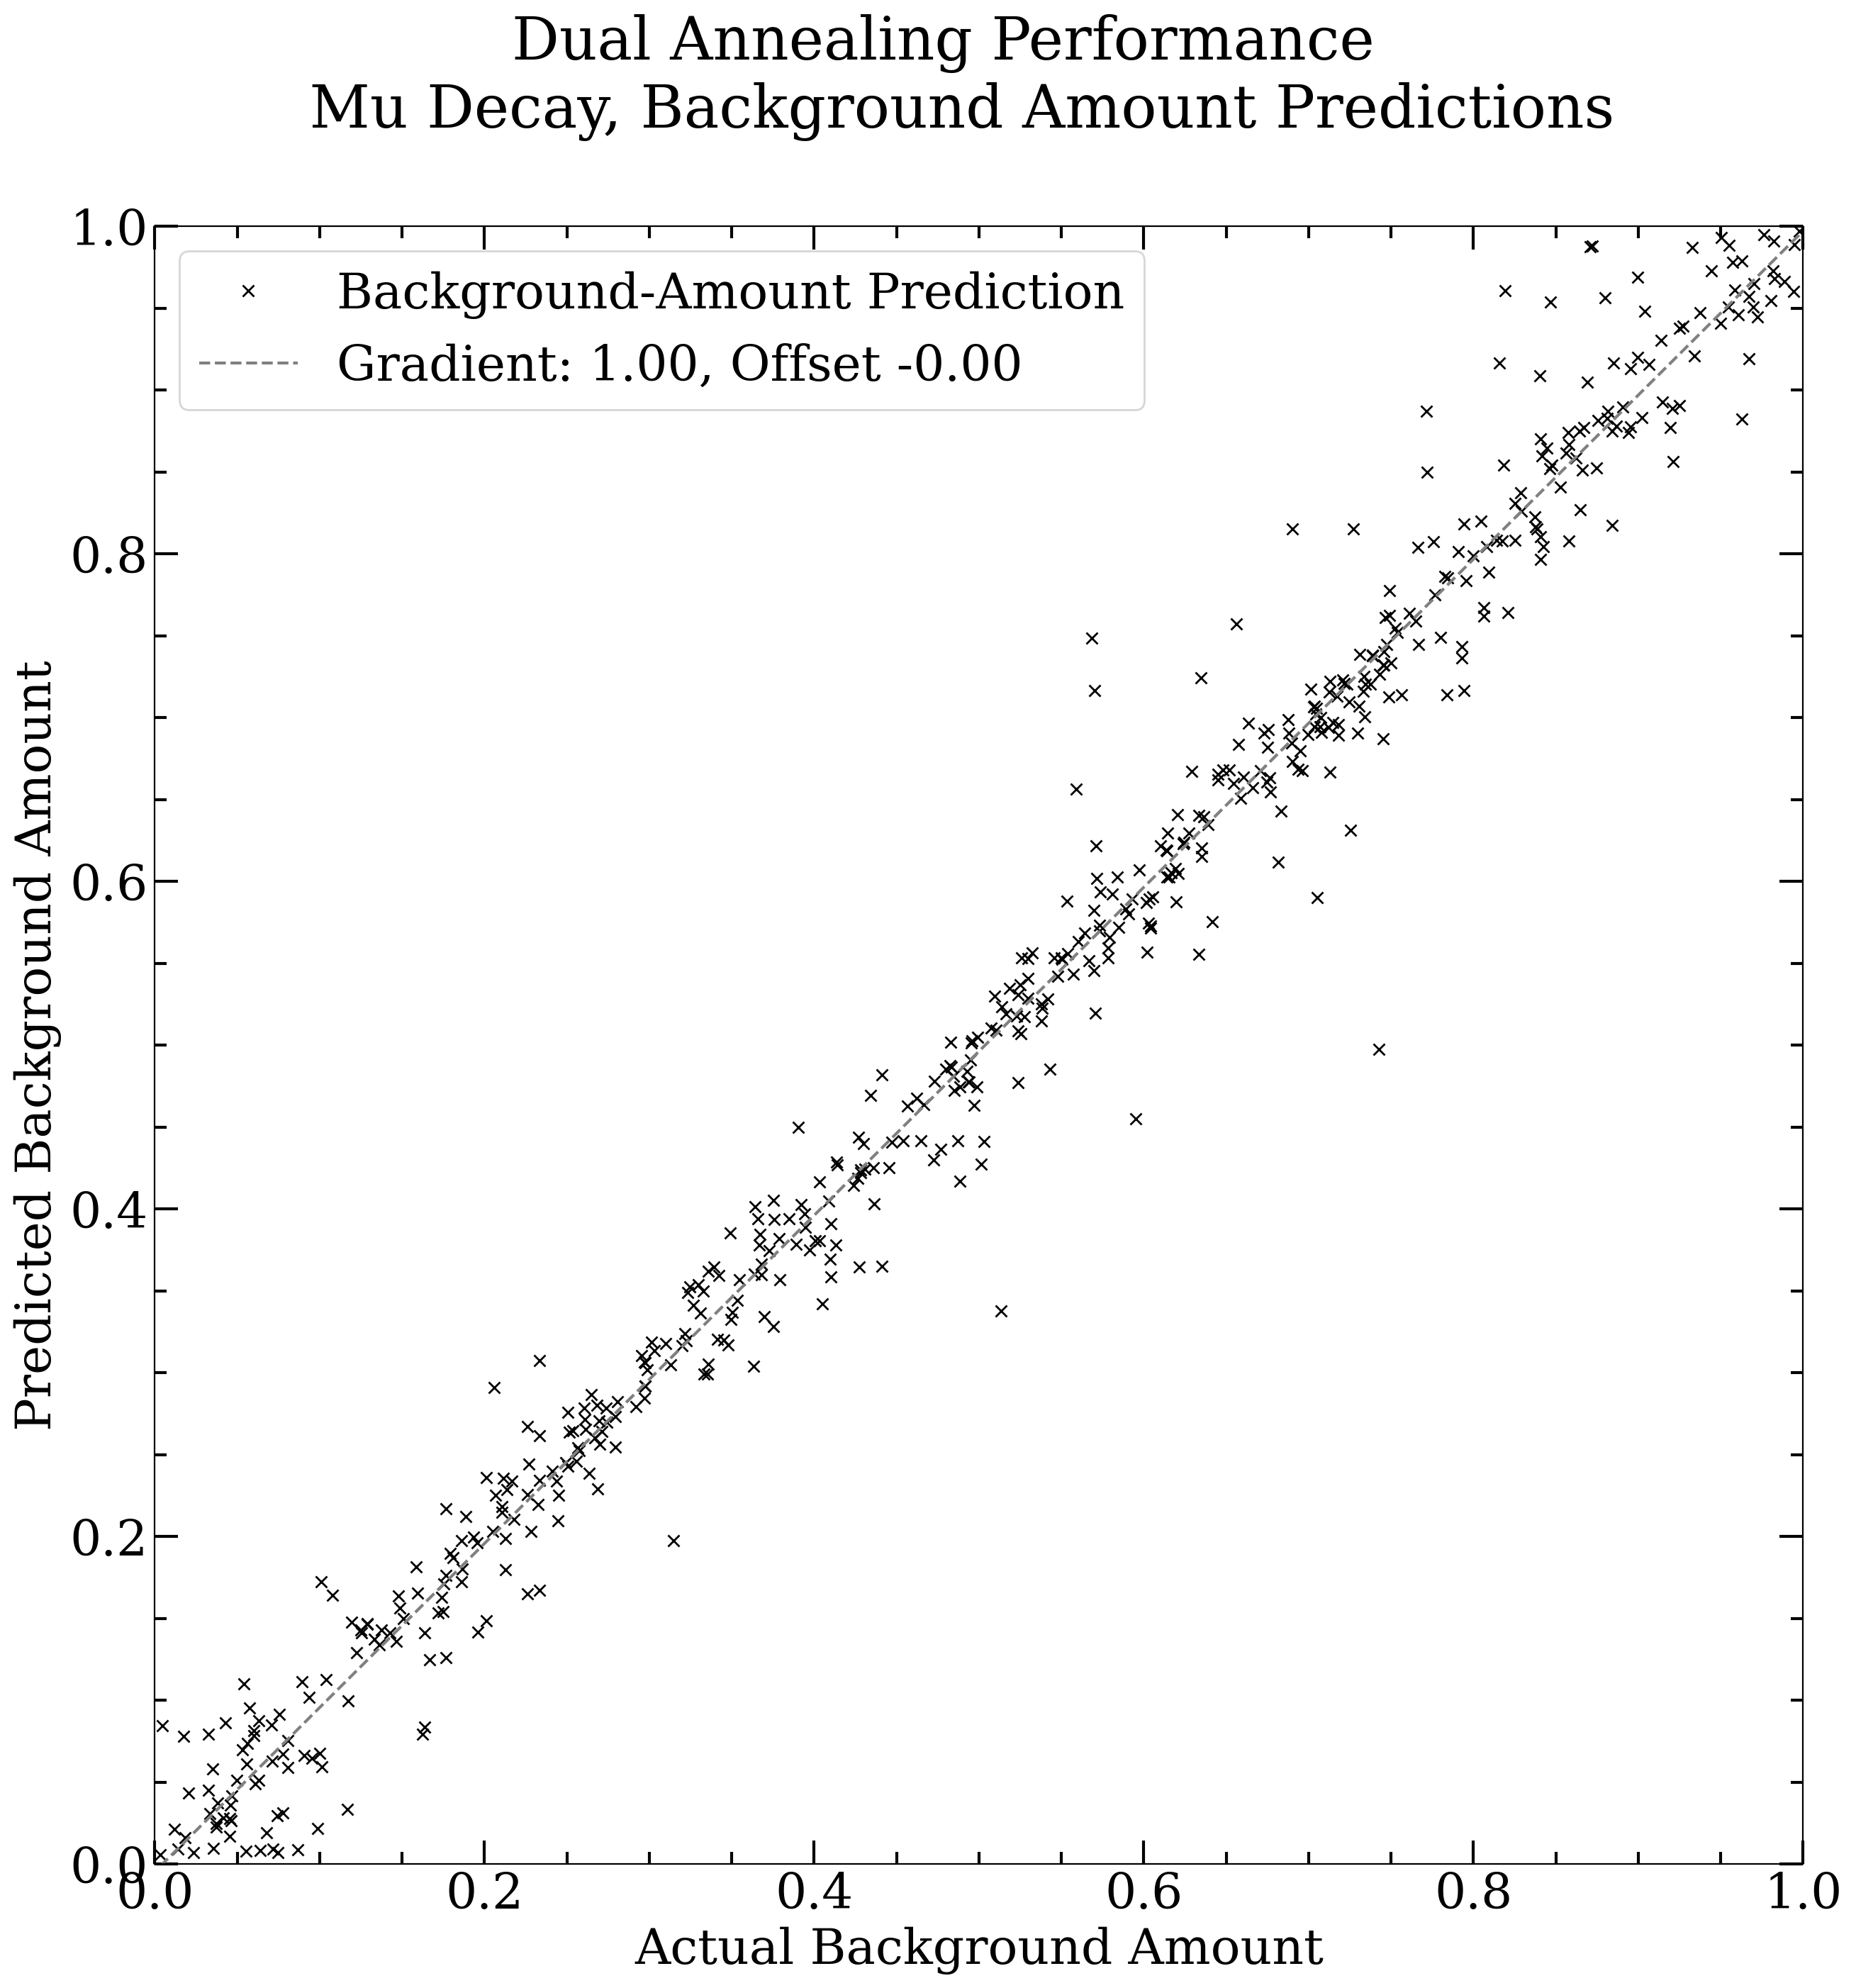

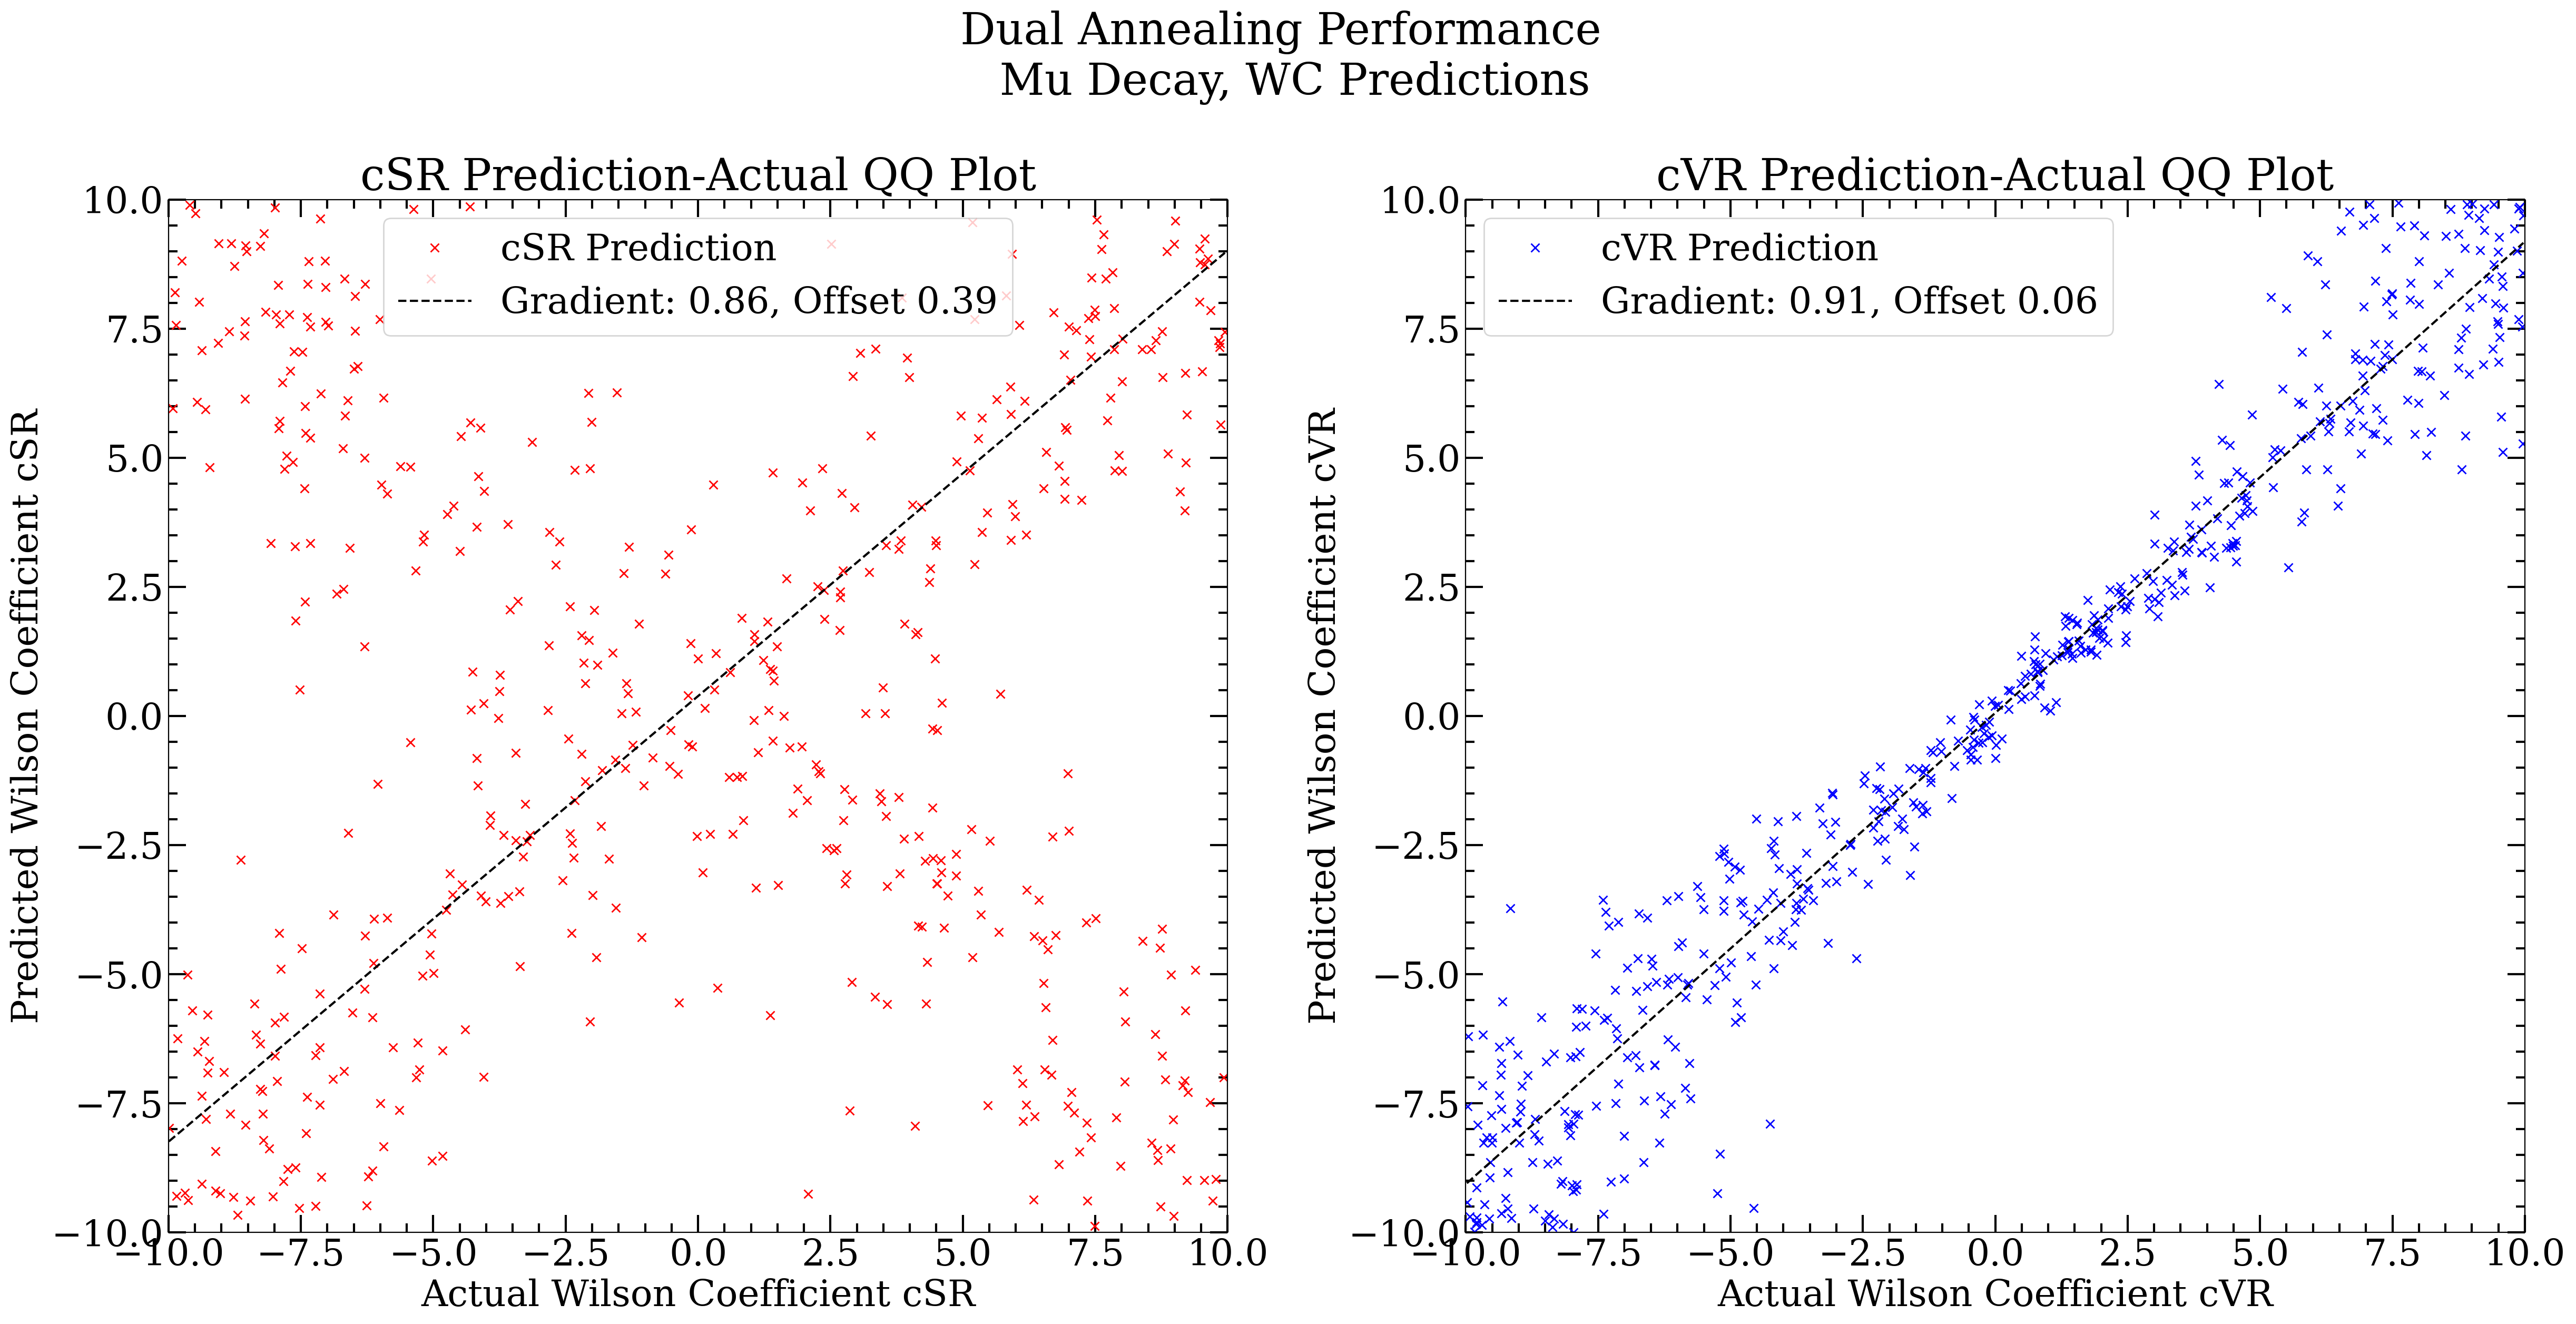

In [21]:
# csr_err, cvr_err, bkg_err = np.loadtxt('fit_results/dual_annealing_errors_med.txt', dtype=float, unpack=True, delimiter=',')

vals = np.loadtxt('dual_annealing_single_mu.txt', delimiter=',')
obj_cvae = vals[:, :3]
pred_cvae = vals[:, 3:]

perc_csr = 0 / pred_cvae[:, 0]
perc_cvr = 0 / pred_cvae[:, 1]
perc_bkg = 0 / pred_cvae[:, 2]

resc_pred = deepcopy(pred_cvae)
resc_obj = deepcopy(obj_cvae)

resc_pred[:, :2] = (pred_cvae[:, :2] * 20) - 10
resc_obj[:, :2] = (obj_cvae[:, :2] * 20) - 10

# QQ_Plot(pred_linear[:, idx], obj_linear[:, idx])
figure = QQ_Plot(resc_obj, resc_pred, perc_csr, perc_cvr, background=True)

## Performance Metrics

In [44]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_predictions(prediction, objective):
    """
    Evaluates the accuracy of predictions compared to the objective values for each column separately.

    Parameters
    ----------
    pred_updated : np.ndarray
        Array of predicted values with shape (n, 2).
    objective : np.ndarray
        Array of actual values with shape (n, 2).

    Returns
    -------
    metrics : dict
        Dictionary containing the evaluation metrics for each column.
    """
    metrics = {}

    # Identify conditions for reflection
    # mask_1 = (objective < 0.5) & (prediction > 0.5) | (objective > 0.5) & (prediction < 0.5)

    # Create updated prediction lists with reflections where necessary
    # pred_updated = np.where(mask_1, 1 - prediction, prediction)

    for i in range(prediction.shape[1]):
        col_pred = prediction[:, i]
        col_obj = objective[:, i]

        mae = mean_absolute_error(col_obj, col_pred)
        mse = mean_squared_error(col_obj, col_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(col_obj, col_pred)

        metrics[f'Column {i+1}'] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R²': r2
        }

    return metrics

In [45]:
met = evaluate_predictions(resc_pred, resc_obj)

## Fit Outputs Histogram

In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from scipy.optimize import dual_annealing
import json
import os

split = csr_cvae.split('/')
normal_path = os.path.join(split[0], split[1])
cfg = nt.BO_CVAE(normal_path, [[1, 2]], [[0] * 10000])

model_cvae = nt.CVAE_Opt(input_shape=cfg['dim'][0], output_shape=cfg['dim'][1], latent_dim=cfg['latent_dim'], encoder_layers=cfg['encoder'], decoder_layers=cfg['decoder'],
            dropout_enc=cfg['encoder_drop'], dropout_dec=cfg['decoder_drop'])

model_cvae.load_state_dict(torch.load(csr_cvae, map_location=DEVICE, weights_only=False))
model_cvae.to(DEVICE)
model_cvae.eval()


def model_outputs_CVAE(wilson, model_cvae):
    w1, w2 = wilson
    input = torch.Tensor(np.array([[w1, w2]])).to(DEVICE)

    # =-=-= CVAE Method of Reading Outputs =-=-=
    outputs = model_cvae.generate_histogram(input)
    outputs = outputs.to('cpu')
    
    return outputs.detach().numpy()

csv_path = 'nn_outputs/wilson_tau_csr_cvr/normal_targets/model_WET_tau_8.csv'
json_path = 'nn_outputs/wilson_tau_csr_cvr/normal_inputs/model_WET_tau_8.json'

with open(json_path, 'r') as f:
    wilsons = json.load(f)

data = pd.read_csv(csv_path)
eos_bin_heights = data['bin_height'].values

checkpoints = []
def callback(x, f, context):
    checkpoints.append(x)

bounds = [(0,1)] * 2
result = dual_annealing(MSE_CVAE, bounds, maxfun=1e3, callback=callback).x

checkpoints = np.array(checkpoints) * 20 - 10

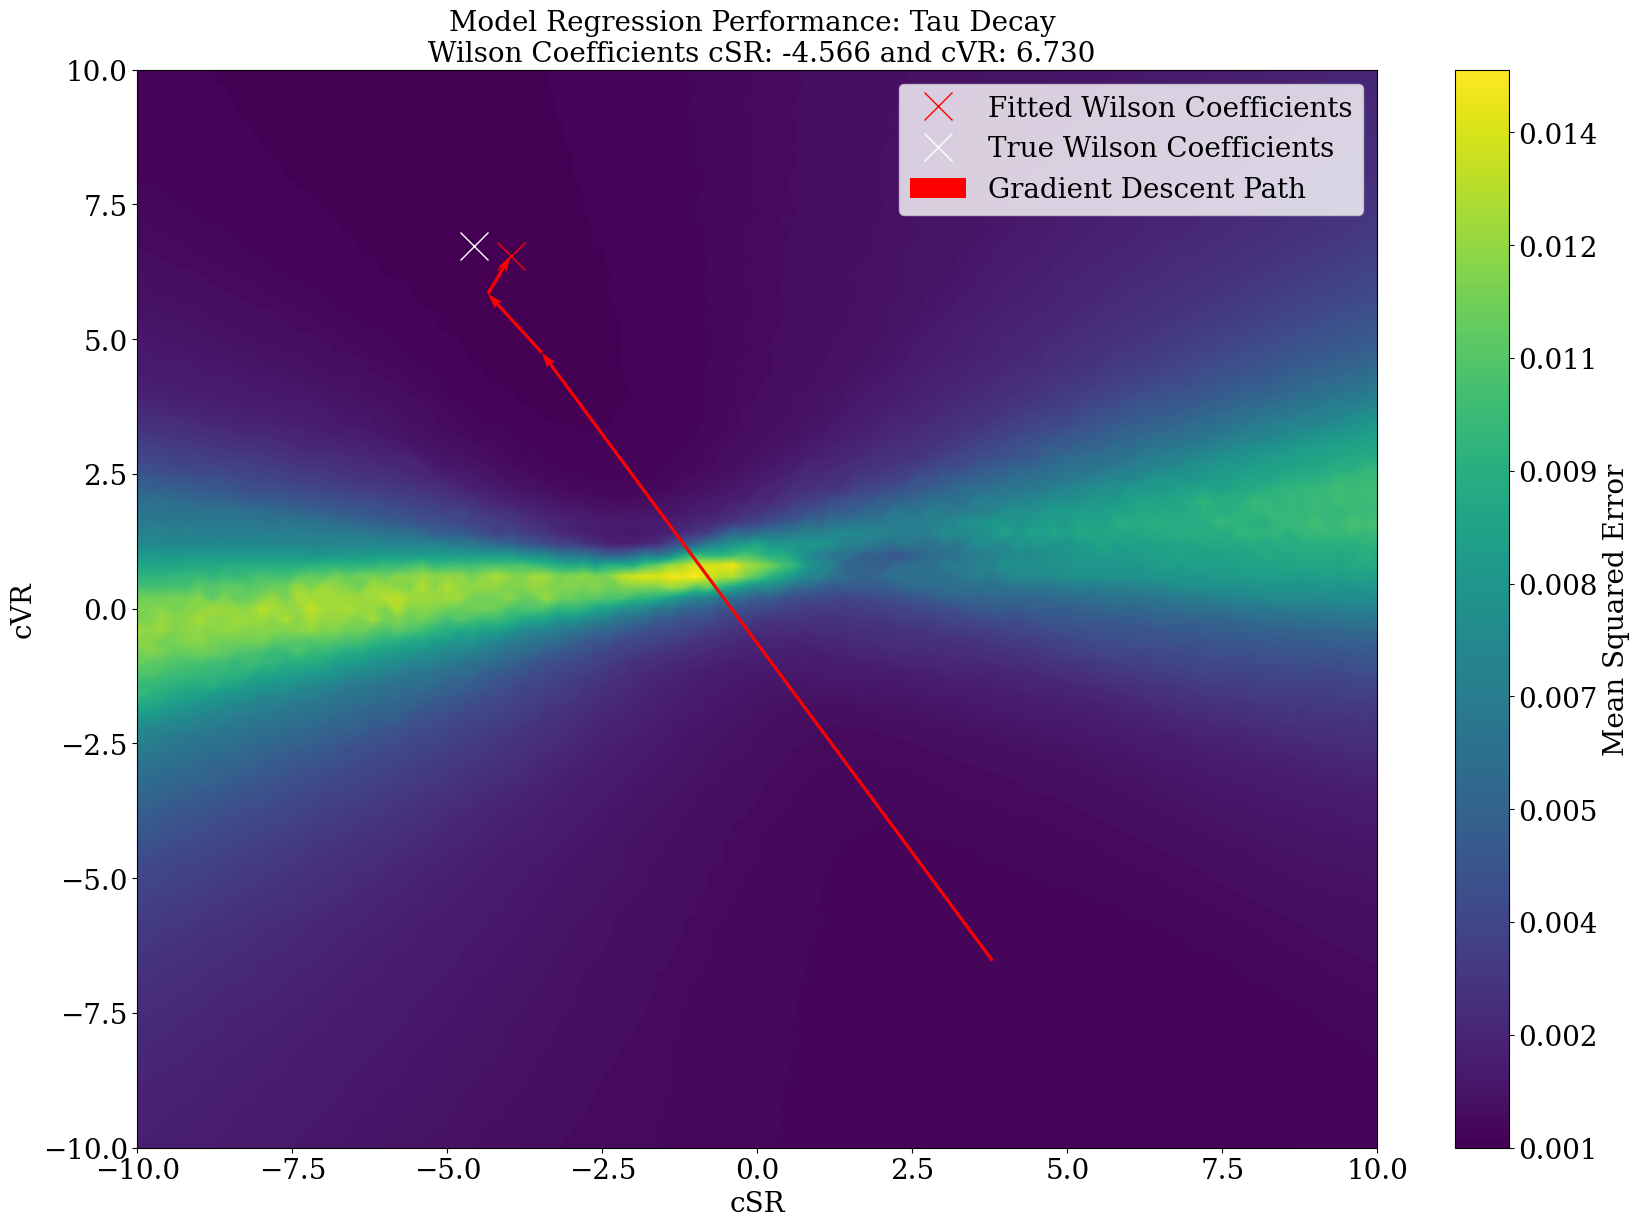

In [225]:
csr = np.linspace(0, 1, 101, endpoint=True)
cvr = np.linspace(0, 1, 101, endpoint=True)

csr_grid, cvr_grid = np.meshgrid(csr, cvr)
stack = np.stack([csr_grid.ravel(), cvr_grid.ravel()], axis=1)

wilson_tensor = torch.Tensor(stack).to(DEVICE)

def model_eval(csr, cvr, model):
    csr_grid, cvr_grid = np.meshgrid(csr, cvr)
    inputs = np.stack([csr_grid.ravel(), cvr_grid.ravel()], axis=1)
    inputs = torch.tensor(inputs, dtype=torch.float32).to(DEVICE)

    with torch.no_grad():
        outputs = model.generate_histogram(inputs)
        outputs = outputs.to('cpu').detach().numpy()

    return outputs

model_bins = model_eval(csr, cvr, model_cvae)
diff = np.mean((eos_bin_heights - model_bins)**2, axis=1)
mse_reshaped = diff.reshape(101, 101)

plt.rcParams["font.family"] = "Serif"
plt.rcParams['font.size'] = 20

plt.figure(figsize=(20, 14))
contour = plt.contourf((csr * 20) - 10, (cvr * 20) - 10, mse_reshaped, cmap='viridis', levels=200)
cbar = plt.colorbar(contour, format='%.3f')
cbar.set_label('Mean Squared Error')

plt.xlabel('cSR', fontsize=20)
plt.ylabel('cVR', fontsize=20)
plt.title(f'Model Regression Performance: Tau Decay \n Wilson Coefficients cSR: {list(wilsons.values())[0] * 20 - 10:.3f} and cVR: {list(wilsons.values())[1] * 20 - 10:.3f}', fontsize=20)

# Plot the path followed by the algorithm
plt.plot(result[0] * 20 - 10, result[1]* 20 - 10, 'x', markersize=20, color='red', label='Fitted Wilson Coefficients')
plt.plot(wilsons['wc_0'] * 20 - 10, wilsons['wc_1']* 20 - 10, 'x', markersize=20, color='white', label='True Wilson Coefficients')

# plt.plot(checkpoints[:, 0], checkpoints[:, 1], 'ro-', markersize=5, label='Path')
plt.quiver(checkpoints[:-1, 0], checkpoints[:-1, 1], 
           checkpoints[1:, 0] - checkpoints[:-1, 0], 
           checkpoints[1:, 1] - checkpoints[:-1, 1], 
           scale_units='xy', angles='xy', scale=1.0, width=0.0025, color='red', label='Gradient Descent Path')

plt.legend()
plt.show()